In [159]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
import torch
import models
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import dataloader as dataloader
import random
pth_path = '/home/hao/Project/uni-cmae/egs/voxceleb2/exp/testmae02-audioset-uni-cmae-balNone-lr5e-5-epoch25-bs60-normTrue-c0.01-p1.0-tpFalse-mr-0.9-0.75/models/audio_model.1.pth'
# 初始化模型和优化器
audio_model = models.Uni_CMAE(img_size=160, audio_length=1024, norm_pix_loss=True, encoder_depth=12, tr_pos=False, pred_t_dim=8)
optimizer = torch.optim.Adam(audio_model.parameters(), lr=0.0001)

mdl_weight = torch.load(pth_path, map_location=torch.device('cpu'))

# 处理键名不匹配问题
new_state_dict = {}
for k, v in mdl_weight.items():
    if k.startswith('module.'):
        k = k[len('module.'):]
    # if k not in ['decoder_pred_v.weight', 'decoder_pred_v.bias']:  # 忽略这些层
    #     new_state_dict[k] = v
    new_state_dict[k] = v
# # 调整 pos_embed_v 和 decoder_pos_embed_v 的形状 # TODO:后期在预训练模型里面调整，这个view的功能可以去掉
# if 'pos_embed_v' in new_state_dict:
#     new_state_dict['pos_embed_v'] = new_state_dict['pos_embed_v'].view(audio_model.pos_embed_v.shape)
# if 'decoder_pos_embed_v' in new_state_dict:
#     new_state_dict['decoder_pos_embed_v'] = new_state_dict['decoder_pos_embed_v'].view(audio_model.decoder_pos_embed_v.shape)

msg = audio_model.load_state_dict(new_state_dict, strict=False)

print('missing_keys:', msg.missing_keys)
print('unexpected_keys:', msg.unexpected_keys)

val_audio_conf = {
    'num_mel_bins': 128,
    'target_length': 1024,
    'freqm': 0,
    'timem': 0,
    'mixup': 0,
    'dataset': 'audioset',
    'mode': 'test', # "pretrain", "finetune", "val", "test"
    'noise': False,
    'im_res': 160,
    'mean': -5.081,  # 添加 norm_mean
    'std': 4.4849    # 添加 norm_std
}
video_conf = {
    'dataset_type': 'video',
    'aa_type': "rand-m7-n4-mstd0.5-inc1",
    'pretrain_rand_flip': True,
    'pretrain_rand_erase_prob': 0.25,
    'pretrain_rand_erase_mode': "pixel",
    'pretrain_rand_erase_count': 1,
    'pretrain_rand_erase_split': False,
    'jitter_aspect_relative': [0.75, 1.3333],
    'jitter_scales_relative': [0.5, 1.0],
    'repeat_aug': 1,
    'num_retries': 10,
    'train_jitter_scales': (256, 320),
    'train_crop_size': 160,
    'train_random_horizontal_flip': True,
    'test_num_ensemble_views': 10,
    'test_num_spatial_crops': 3,
    'test_crop_size': 160,
    'sampling_rate': 4,
    'num_frames': 16,
    'target_fps': 30,
    'mean': (0.45, 0.45, 0.45),
    'std': (0.225, 0.225, 0.225),
    'enable_multi_thread_decode': False,
    'inverse_uniform_sampling': False,
    'use_offset_sampling': True
}
val_set = dataloader.AudiosetDataset(
    dataset_json_file='/home/hao/Project/uni-cmae/egs/voxceleb2/test_data.json',
    label_csv='/home/hao/Project/uni-cmae/egs/voxceleb2/class_labels_indices.csv',
    audio_conf=val_audio_conf,
    video_conf=video_conf,
)


A Uni-CMAE Model
Use norm_pix_loss:  True
Learnable Positional Embedding:  False
img_size (160, 160) patch_size (16, 16) frames 16 t_patch_size 2
Number of Audio Patches: 512, Visual Patches: 800
pos_embed_v_t shape: torch.Size([1, 8, 768])
pos_embed_v_s shape: torch.Size([1, 100, 768])
pos_embed_v shape: torch.Size([1, 8, 100, 768])
decoder_pos_embed_v_t shape: torch.Size([1, 8, 512])
decoder_pos_embed_v_s shape: torch.Size([1, 100, 512])
decoder_pos_embed_v shape: torch.Size([1, 8, 100, 512])
decoder_pos_embed_v_trans shape: torch.Size([1, 800, 512])
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 8, 100, 768])
missing_keys: []
unexpected_keys: ['norm_a.weight', 'norm_a.bias', 'norm_v.weight', 'norm_v.bias']
Dataset has 36237 samples
Using Label Smoothing: 0.0
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
using video data as video input
use dataset mean -5.081 and std 4.4

In [161]:

# 获取 val_set 中的一个样本
index = random.randint(0, len(val_set))
print(f'index: {index}')
audio, video, label = val_set[index]


index: 34243


In [162]:

# 前向传播
pred_video, pred_audio, mask_v, mask_a, video, audio = audio_model.forward_vis(audio.unsqueeze(0), video.unsqueeze(0), mask_ratio_a=0.5, mask_ratio_v=0.9)

# 处理输出数据的 shape
video = video.squeeze(0).permute(1, 0, 2, 3).detach().cpu().numpy()  # (8, 3, 160, 160)
audio = audio.squeeze(0).squeeze(0).transpose(0,1).detach().cpu().numpy()  # (1024, 128)
pred_video = pred_video.squeeze(0).permute(1, 0, 2, 3).detach().cpu().numpy()  # (8, 3, 160, 160)
pred_audio = pred_audio.squeeze(0).squeeze(0).transpose(0, 1).detach().cpu().numpy()  # (1024, 128)
mask_v = mask_v.squeeze(0).detach().cpu().numpy()  # (800,)
mask_a = mask_a.squeeze(0).detach().cpu().numpy()  # (512,)


print(f'video shape: {video.shape}, audio shape: {audio.shape}')
print(f'pred_video shape: {pred_video.shape}, pred_audio shape: {pred_audio.shape}')
print(f'mask_v shape: {mask_v.shape}, mask_a shape: {mask_a.shape}')

# Normalize video frames and predictions to [0, 1]
video = np.clip((video - video.min()) / (video.max() - video.min()), 0, 1)
pred_video = np.clip((pred_video - pred_video.min()) / (pred_video.max() - pred_video.min()), 0, 1)

pred_a shape: torch.Size([1, 512, 256]), pred_v shape: torch.Size([1, 800, 768])
video shape: (8, 3, 160, 160), audio shape: (1024, 128)
pred_video shape: (8, 3, 160, 160), pred_audio shape: (1024, 128)
mask_v shape: (800,), mask_a shape: (512,)


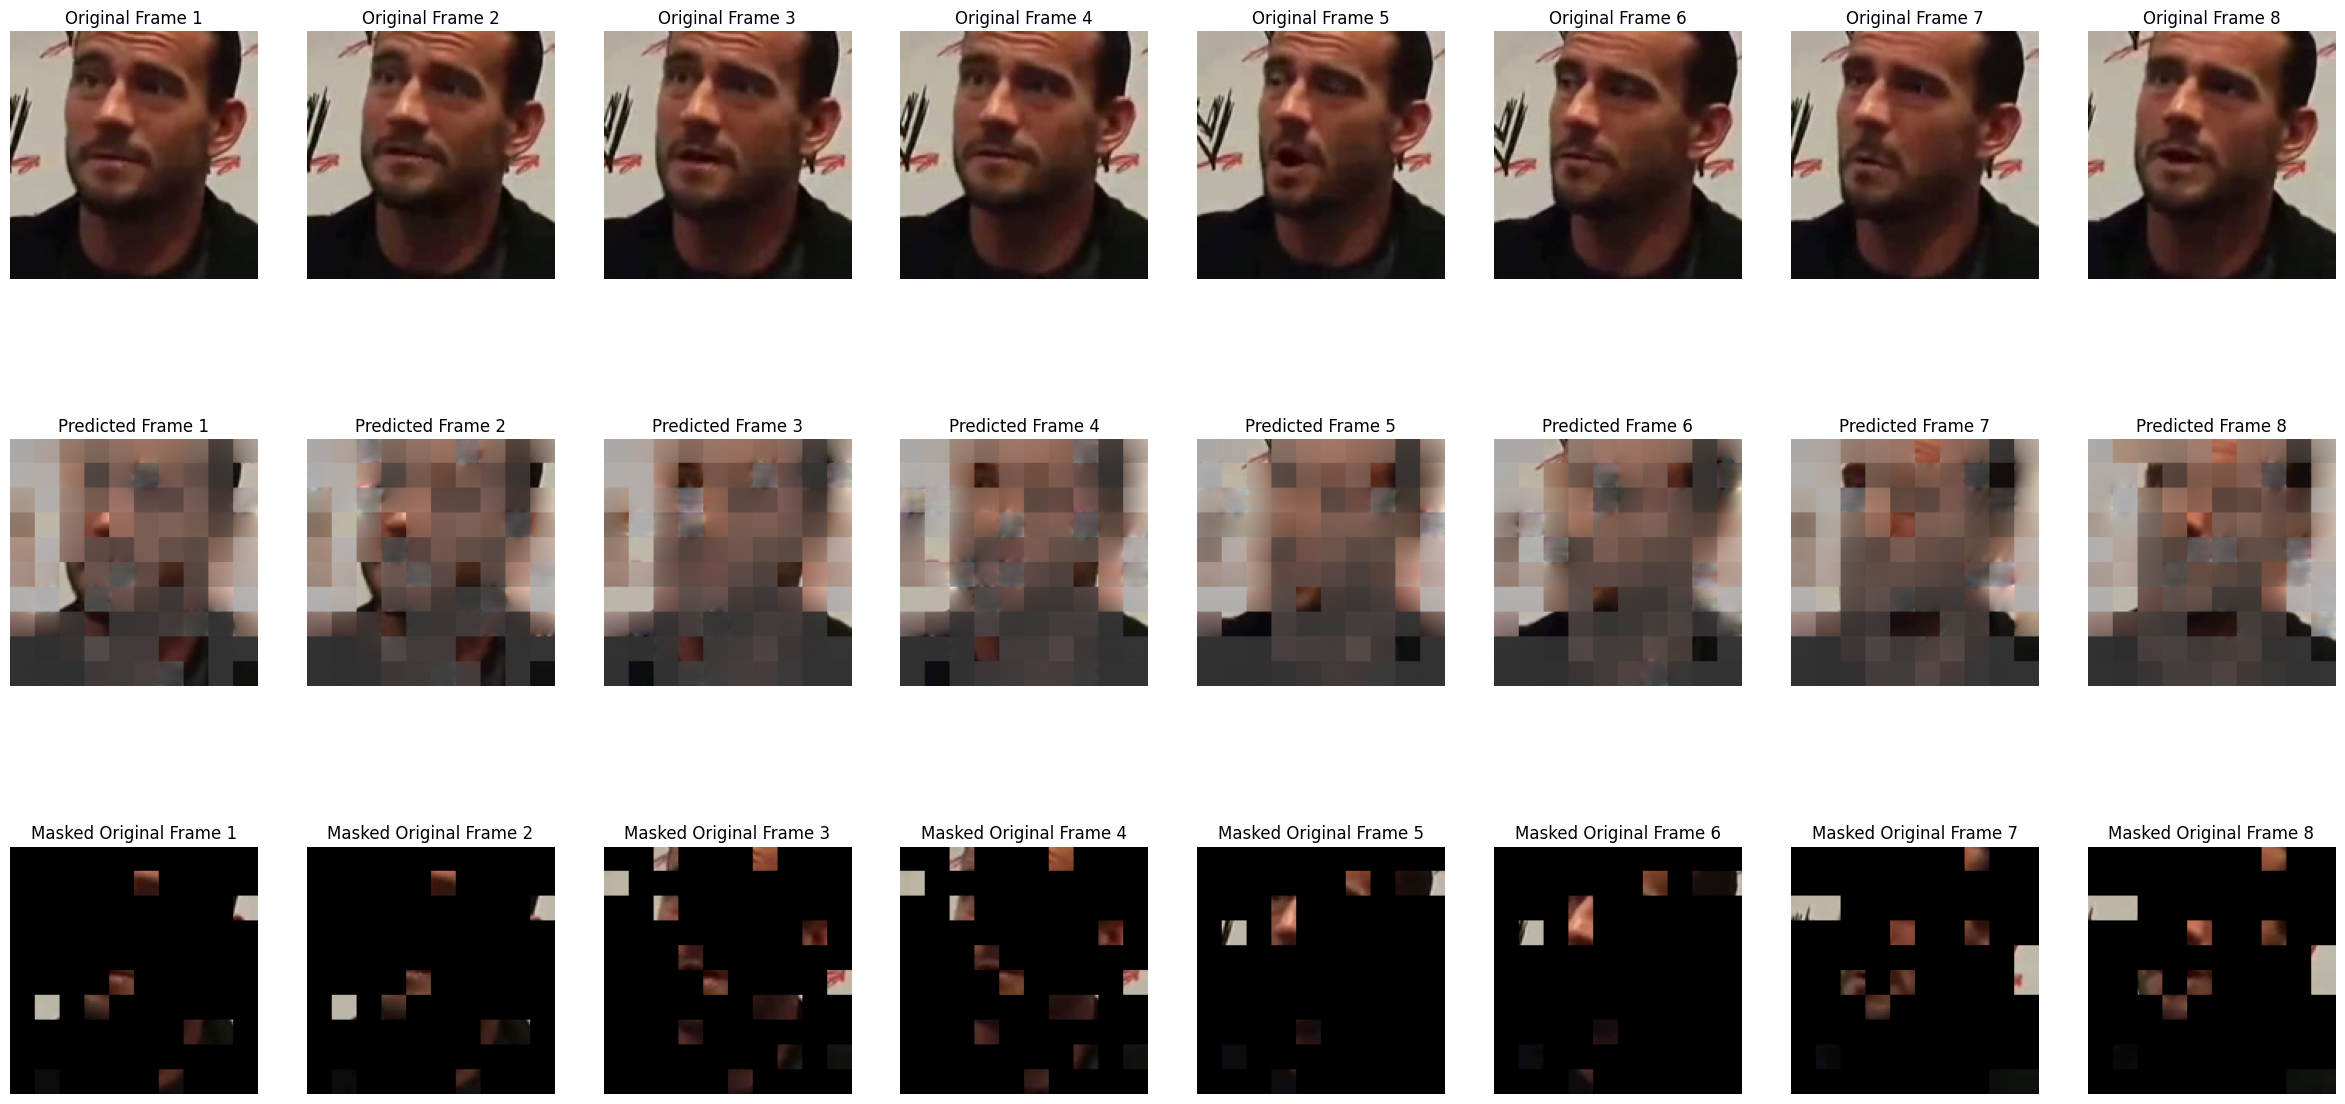

In [163]:
# Visualization
fig, axes = plt.subplots(3, video.shape[0], figsize=(30, 15))
patch_size = 16

for i in range(video.shape[0]):
    idx = i
    # Original video frame
    axes[0, idx].imshow(np.transpose(video[i], (1, 2, 0)))
    axes[0, idx].axis('off')
    axes[0, idx].set_title(f'Original Frame {i+1}')

    # Predicted frame with real unmasked regions
    pred_frame_with_real = np.transpose(pred_video[i], (1, 2, 0)).copy()
    real_frame = np.transpose(video[i], (1, 2, 0)).copy()

    # Adjust mask shape to match video frames
    mask = mask_v.reshape(video.shape[0] // 2, video.shape[2] // patch_size, -1)
    mask = np.repeat(mask, 2, axis=0)  # Repeat mask for each pair of frames # 这里哦！

    for y in range(mask.shape[1]):
        for x in range(mask.shape[2]):
            if mask[i, y, x] == 0:
                pred_frame_with_real[y*patch_size:(y+1)*patch_size, x*patch_size:(x+1)*patch_size, :] = \
                    real_frame[y*patch_size:(y+1)*patch_size, x*patch_size:(x+1)*patch_size, :]
    
    axes[1, idx].imshow(pred_frame_with_real)
    axes[1, idx].axis('off')
    axes[1, idx].set_title(f'Predicted Frame {i+1}')

    # Masked original video frame
    masked_frame = video[i].copy() # 如何对8帧做呢？下面这句的idx//2全变成idx， 然后上面的repeat去掉即可
    mask = mask_v[idx // 2 * (video.shape[2] // patch_size) * (video.shape[3] // patch_size):(idx // 2 + 1) * (video.shape[2] // patch_size) * (video.shape[3] // patch_size)]
    mask = mask.reshape(video.shape[2] // patch_size, video.shape[3] // patch_size)
    
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x] > 0:
                masked_frame[:, y*patch_size:(y+1)*patch_size, x*patch_size:(x+1)*patch_size] = 0
    
    axes[2, idx].imshow(np.transpose(masked_frame, (1, 2, 0)))
    axes[2, idx].axis('off')
    axes[2, idx].set_title(f'Masked Original Frame {i+1}')

plt.show()

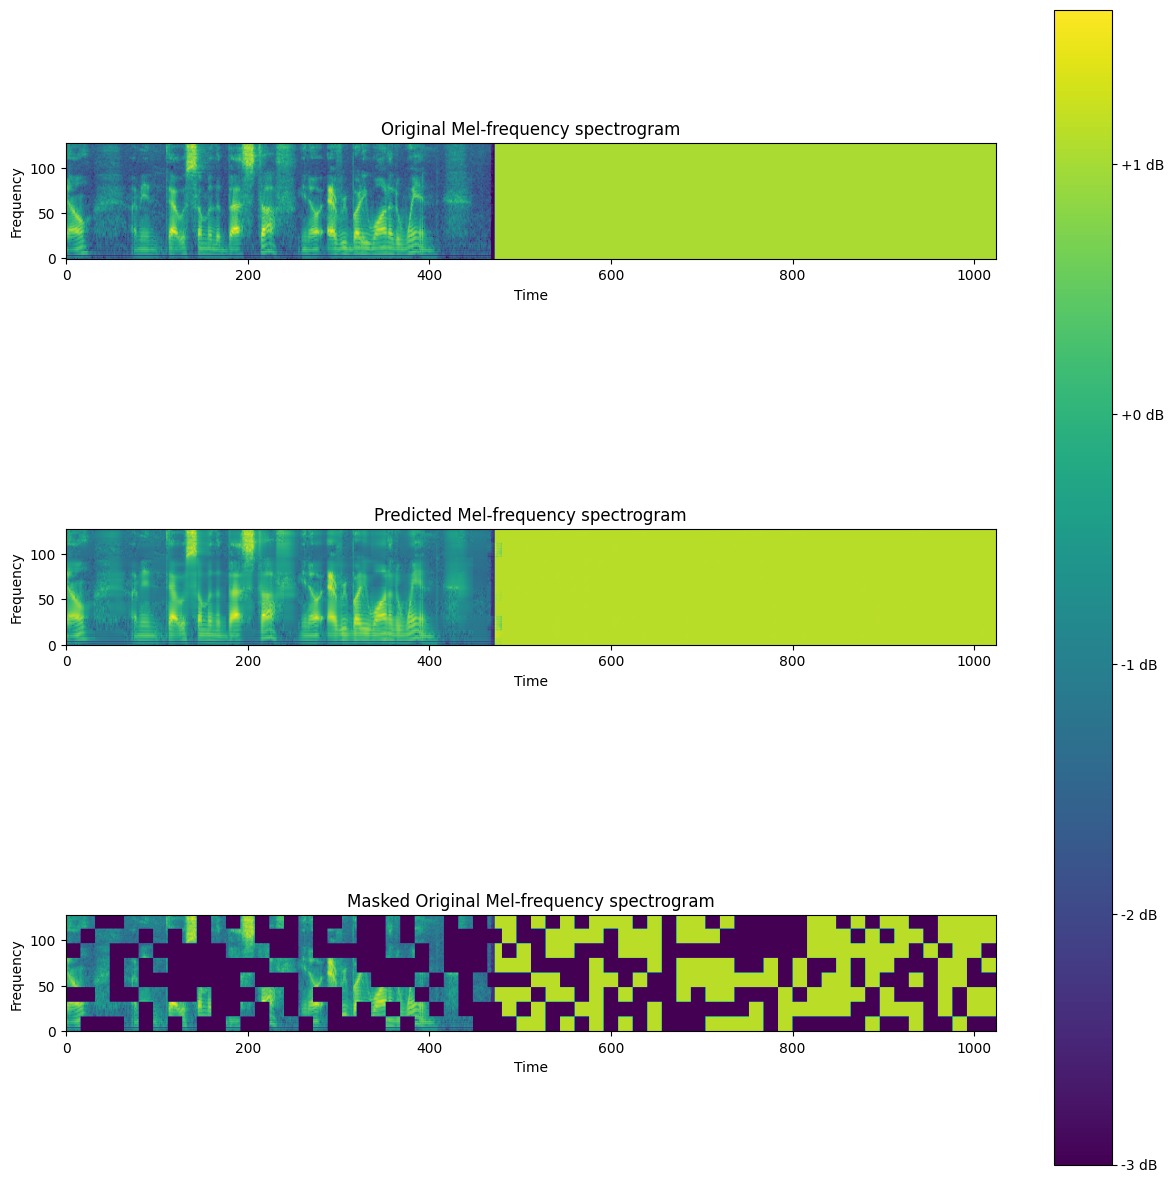

In [164]:
# 可视化原始频谱图、预测频谱图和掩码后的频谱图
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
plt.subplots_adjust(hspace=0.01)  # 增加子图之间的间距

# 原始频谱图
im0 = axes[0].imshow(audio.T, aspect='equal', origin='lower')
axes[0].set_title('Original Mel-frequency spectrogram')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Frequency')

# 预测频谱图
pred_audio_copy = pred_audio.copy()
mask_a_copy = mask_a.reshape(-1, 8)
for i in range(mask_a_copy.shape[0]):
    for j in range(mask_a_copy.shape[1]):
        if mask_a_copy[i, j] == 0:
            pred_audio_copy[i * 16:(i + 1) * 16, j * 16:(j + 1) * 16] = audio[i * 16:(i + 1) * 16, j * 16:(j + 1) * 16]

im1 = axes[1].imshow(pred_audio_copy.T, aspect='equal', origin='lower')
axes[1].set_title('Predicted Mel-frequency spectrogram')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')

# 掩码后的频谱图
masked_audio = audio.copy()
mask = mask_a.reshape(-1, 8)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i, j] > 0:
            masked_audio[i * 16:(i + 1) * 16, j * 16:(j + 1) * 16] = -3

im2 = axes[2].imshow(masked_audio.T, aspect='equal', origin='lower')
axes[2].set_title('Masked Original Mel-frequency spectrogram')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Frequency')

# 只显示一个颜色条
fig.colorbar(im2, ax=axes.ravel().tolist(), orientation='vertical', format='%+2.0f dB')

plt.show()

In [165]:
# import librosa
# import librosa.display
# import numpy as np
# import matplotlib.pyplot as plt
# import soundfile as sf

# # 定义采样率
# sr = 25000

# # 将梅尔频谱图转换为音频信号
# def mel_to_audio(mel_spectrogram, sr=sr, n_fft=2048, hop_length=512, fmax=None):
#     # 反梅尔变换
#     mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
#     audio_signal = librosa.feature.inverse.mel_to_audio(mel_spectrogram_db, sr=sr, n_fft=n_fft, hop_length=hop_length, fmax=fmax)
#     return audio_signal



# # 将预测的梅尔频谱图转换为音频信号
# predicted_audio_signal = mel_to_audio(pred_audio_copy, sr=sr, n_fft=2048, hop_length=512, fmax=sr//2)
# sf.write('predicted_audio.wav', predicted_audio_signal, sr)

In [166]:
# %reset -f